# Evaporation from ZAMG data
*A. Kokimova, November 2021, University of Graz*

Data source: ZAMG - https://data.hub.zamg.ac.at

What is done:

- load the data from ZAMG
- estimate potential evaporation
- plot and store results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyet
pyet.show_versions()

Python version: 3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.20.2
Scipy version: 1.7.0
Pandas version: 1.3.4
Matplotlib version: 3.3.4
Pyet version: 1.0.1


## Loading daily data from ZAMG (Messstationen Tagesdaten)

station: Graz Universität 16412

Selected variables:
- globalstrahlung (global radiation), J/cm2 needs to be in MJ/m3d, ZAMG abbreviation - strahl
- arithmetische windgeschwindigkeit (wind speed), m/s, ZAMG abbreviation - vv
- relative feuchte (relative humidity), %, ZAMG abbreviation - rel
- lufttemparatur (air temperature) in 2 m, C, ZAMG abbreviation - t
- lufttemperatur (air temperature) max in 2 m, C, ZAMG abbreviation - tmax
- lufttemperatur (air temperature) min in 2 m, C, ZAMG abbreviation - tmin
- latitute and elevation of a station

In [4]:
#read data
data_16412 = pd.read_csv('../klima_daily.csv', index_col=1, parse_dates=True)
data_16412

,station,strahl,vv,rel,t,tmin,tmax
time,,,,,,,
2000-01-01,16412,300.0,1.0,80.0,-2.7,-5.8,0.5
2000-01-02,16412,250.0,1.0,86.0,0.2,-2.1,2.5
2000-01-03,16412,598.0,1.0,86.0,0.6,-2.4,3.6
2000-01-04,16412,619.0,1.0,83.0,-0.5,-5.5,4.5
2000-01-05,16412,463.0,1.0,84.0,-0.1,-5.5,5.4
...,...,...,...,...,...,...,...
2021-11-27,16412,160.0,1.1,92.0,1.2,0.3,2.1
2021-11-28,16412,183.0,1.1,94.0,1.4,0.3,2.4
2021-11-29,16412,606.0,1.6,77.0,2.0,-0.8,4.7


## Calculate PET for Graz Universität - 16412

In [7]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100

meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})
time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

lat = 47.077778*np.pi/180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

# Estimate evaporation with four different methods and create a dataframe
pet_u = pd.DataFrame()
pet_u["pe_penman"] = pyet.penman(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_u["pe_pt"] = pyet.priestley_taylor(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_u["pe_makkink"] = pyet.makkink(tmean, rs, elevation=elevation)
pet_u["pe_fao56"] = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_u["pe_oudin"] = pyet.oudin(tmean, lat=lat)
pet_u

,pe_penman,pe_pt,pe_makkink,pe_fao56,pe_oudin
time,,,,,
2000-01-01,0.235533,0.165802,0.284784,0.289521,0.087023
2000-01-02,0.273596,0.240617,0.267085,0.304319,0.198423
2000-01-03,0.027743,-0.072024,0.648786,0.097245,0.215092
2000-01-04,0.038275,-0.079725,0.643382,0.120885,0.173807
2000-01-05,0.152905,0.068217,0.488891,0.215709,0.190662
...,...,...,...,...,...
2021-11-27,0.200695,0.189043,0.177575,0.216952,0.257866
2021-11-28,0.220198,0.229278,0.204623,0.221539,0.263636
2021-11-29,0.167681,-0.013680,0.692731,0.361746,0.285796


### Plot results

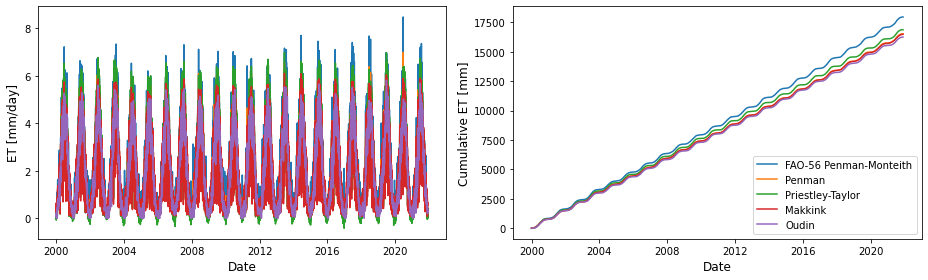

In [8]:
fig, axs = plt.subplots(figsize=(13,4), ncols=2)
axs[0].plot(pet_u['pe_fao56'], label = "FAO-56 Penman-Monteith")
axs[0].plot(pet_u['pe_penman'],label="Penman")
axs[0].plot(pet_u['pe_pt'], label="Priestley-Taylor")
axs[0].plot(pet_u['pe_makkink'], label="Makkink")
axs[0].plot(pet_u['pe_oudin'], label="Oudin")

axs[1].plot(pet_u['pe_fao56'].cumsum(), label="FAO-56 Penman-Monteith")
axs[1].plot(pet_u['pe_penman'].cumsum(),label="Penman")
axs[1].plot(pet_u['pe_pt'].cumsum(), label="Priestley-Taylor")
axs[1].plot(pet_u['pe_makkink'].cumsum(), label="Makkink")
axs[1].plot(pet_u['pe_oudin'].cumsum(), label="Oudin")

axs[0].set_ylabel("ET [mm/day]", fontsize=12)
axs[1].set_ylabel("Cumulative ET [mm]", fontsize=12)
for i in (0,1):
    axs[i].set_xlabel("Date", fontsize=12)

plt.tight_layout()
axs[1].legend(loc=4, fontsize=10)

### Store results

In [ ]:
#plt.savefig("evap_16412.png", dpi=300)
#pet_u.to_csv('../evap_16412.csv')